In [1]:
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin

%matplotlib inline

# Data Pipelines

In this exercise, you will practice pasting together multiple feature processing steps into a single pipeline that allows for easy cross-validation and model selection.

## Data

We will use the crime rate data that we have used in previous weeks. This time, we will not drop the first few columns or the rows with missing values in them.

In [2]:
from sklearn.model_selection import train_test_split

# Load some crime data
headers = pd.read_csv('comm_names.txt', squeeze=True)
headers = headers.apply(lambda s: s.split()[1])
crime = (pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data', 
                    header=None, na_values=['?'], names=headers)
#          .iloc[:, 5:]
#          .dropna()
         )

# Set target and predictors
target = 'ViolentCrimesPerPop'
predictors = [c for c in crime.columns if not c == target]

# Train/test split
X = crime[predictors]
y = crime[[target]]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)
# train_df, test_df = train_test_split(crime, random_state=2)

Always start by taking a look at the first few rows of your data.

In [3]:
import sklearn

print sklearn.__version__

0.18.1


In [4]:
X_train.head()

,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,...,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop
55,79.0,17975.0,Cudahycity,10,0.01,0.36,0.01,0.97,0.04,0.04,...,NaN,0.01,0.33,0.26,NaN,NaN,NaN,NaN,0.0,NaN
35,NaN,NaN,Gallupcity,8,0.01,0.67,0.02,0.23,0.07,0.64,...,NaN,0.03,0.14,0.01,NaN,NaN,NaN,NaN,0.0,NaN
6,NaN,NaN,Petalumacity,1,0.05,0.46,0.02,0.88,0.20,0.17,...,NaN,0.03,0.29,0.24,NaN,NaN,NaN,NaN,0.0,NaN
13,NaN,NaN,Waycrosscity,8,0.01,0.36,0.95,0.24,0.03,0.01,...,NaN,0.03,0.12,0.01,NaN,NaN,NaN,NaN,0.0,NaN
48,NaN,NaN,Templecity,8,0.06,0.38,0.33,0.59,0.05,0.25,...,NaN,0.12,0.09,0.01,NaN,NaN,NaN,NaN,0.0,NaN


In [5]:
X_train.shape

(1495, 126)

## EDA

It's always a good idea to start by asking yourself a few questions about the data. For example
- What types of features are there?
- Are there missing values?
- What is the distribution of the target?

#### What types of features are there?

In [6]:
X_train.dtypes.value_counts()

float64    124
int64        1
object       1
dtype: int64

In [7]:
X_train.dtypes

county                  float64
community               float64
communityname            object
fold                      int64
population              float64
householdsize           float64
racepctblack            float64
racePctWhite            float64
racePctAsian            float64
racePctHisp             float64
agePct12t21             float64
agePct12t29             float64
agePct16t24             float64
agePct65up              float64
numbUrban               float64
pctUrban                float64
medIncome               float64
pctWWage                float64
pctWFarmSelf            float64
pctWInvInc              float64
pctWSocSec              float64
pctWPubAsst             float64
pctWRetire              float64
medFamInc               float64
perCapInc               float64
whitePerCap             float64
blackPerCap             float64
indianPerCap            float64
AsianPerCap             float64
OtherPerCap             float64
                         ...   
PctBornS

#### Are there missing values?

In [8]:
X_train.apply(lambda col: col.isnull().sum())

county                   890
community                893
communityname              0
fold                       0
population                 0
householdsize              0
racepctblack               0
racePctWhite               0
racePctAsian               0
racePctHisp                0
agePct12t21                0
agePct12t29                0
agePct16t24                0
agePct65up                 0
numbUrban                  0
pctUrban                   0
medIncome                  0
pctWWage                   0
pctWFarmSelf               0
pctWInvInc                 0
pctWSocSec                 0
pctWPubAsst                0
pctWRetire                 0
medFamInc                  0
perCapInc                  0
whitePerCap                0
blackPerCap                0
indianPerCap               0
AsianPerCap                0
OtherPerCap                1
                        ... 
PctBornSameState           0
PctSameHouse85             0
PctSameCity85              0
PctSameState85

#### What is the distribution of the target?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10fb8c3d0>]], dtype=object)

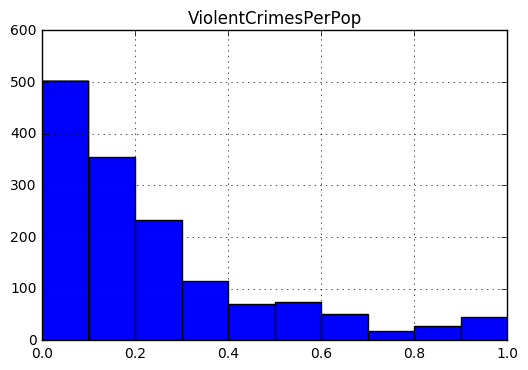

In [9]:
y_train.hist()

#### What are the distributions of the features?

It looks like there are both continuous and categorical features. It is usually a good idea to separate them.

In [10]:
numeric_predictors = X_train.columns[4:]
categorical_predictors = ['county', 'community', 'fold', 'communityname']

##### Numeric

In [11]:
X_train[numeric_predictors].describe().T

,count,mean,std,min,25%,50%,75%,max
population,1495.0,0.056883,0.122571,0.00,0.0100,0.020,0.0600,1.0
householdsize,1495.0,0.464074,0.165073,0.00,0.3500,0.440,0.5400,1.0
racepctblack,1495.0,0.177331,0.252775,0.00,0.0200,0.060,0.2200,1.0
racePctWhite,1495.0,0.752020,0.246175,0.00,0.6300,0.840,0.9400,1.0
racePctAsian,1495.0,0.153860,0.211290,0.00,0.0400,0.070,0.1600,1.0
racePctHisp,1495.0,0.150843,0.239894,0.00,0.0150,0.040,0.1650,1.0
agePct12t21,1495.0,0.423157,0.153432,0.00,0.3300,0.400,0.4800,1.0
agePct12t29,1495.0,0.493331,0.142199,0.00,0.4100,0.480,0.5400,1.0
agePct16t24,1495.0,0.335097,0.163870,0.00,0.2500,0.290,0.3600,1.0
agePct65up,1495.0,0.423880,0.179779,0.00,0.3000,0.420,0.5300,1.0


##### Categorical

In [12]:
for col in categorical_predictors:
    print col
    print X_train[col].value_counts().head()

county
3.0     58
17.0    48
9.0     34
1.0     31
7.0     28
Name: county, dtype: int64
community
21344.0    2
60120.0    2
57000.0    2
2060.0     2
51000.0    2
Name: community, dtype: int64
fold
6     155
4     155
5     154
1     153
10    152
Name: fold, dtype: int64
communityname
Jacksonvillecity    5
Greenvillecity      4
Athenscity          4
Columbuscity        3
Milfordtown         3
Name: communityname, dtype: int64


Both `community` and `communityname` look like they are sliced too thin to be useful. `fold` is probably an index that was added for k-fold cross-validation. So it looks like the only real categorical variable is `county`.

In [13]:
categorical_predictors = ['county']

## Processing

There are a few obvious things we would like to do with this data before we start trying different models.

1. Impute missing values. For categorical variables, this is easy, a good strategy is to just add a new level: '?'. For the continuous variables, we need to be a little bit more careful.
- All of our sklearn learning algorithms only work with numeric data. We need to convert the categorical column to numeric, using either one-hot encoding or feature hashing.
- Some learning algorithms are sensitive to scaling. We should try normalizing the numeric features.
- This dataset has a relatively large number of features, compared to a small number of examples. We might want to try some dimensionality reduction (will be discussed in future classes).

There are different strategies for the two feature types (numeric and categorical), so we will treat them individually.

### Categorical Features

In [14]:
X_train[categorical_predictors].head()

,county
55,79.0
35,NaN
6,NaN
13,NaN
48,NaN


Even though county is being represented with floating point numbers, we don't want the learning algorithm to treat it that way, so we should explicitly change it to a string.

In [15]:
# Change to strings
for col in categorical_predictors:
    X_train.loc[:, col] = X_train[col].astype(str)

/Users/nwchen24/anaconda/envs/Machine_learning_python2/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [16]:
X_train.county.value_counts()

nan      890
3.0       58
17.0      48
9.0       34
1.0       31
7.0       28
27.0      26
5.0       24
21.0      24
13.0      22
23.0      22
11.0      19
25.0      18
29.0      17
35.0      15
39.0      15
31.0      11
133.0     10
71.0      10
79.0       9
15.0       8
119.0      6
45.0       6
61.0       6
101.0      6
49.0       6
93.0       5
91.0       5
77.0       5
19.0       5
        ... 
710.0      1
67.0       1
135.0      1
215.0      1
590.0      1
660.0      1
800.0      1
99.0       1
107.0      1
193.0      1
109.0      1
73.0       1
735.0      1
181.0      1
147.0      1
57.0       1
770.0      1
127.0      1
750.0      1
670.0      1
165.0      1
690.0      1
730.0      1
173.0      1
169.0      1
131.0      1
103.0      1
830.0      1
760.0      1
775.0      1
Name: county, dtype: int64

This actually fixes the second problem as well. The NaN (not a number) entries have just been changed to the string 'nan', which should be treated the same as any other category level.

Now, the approach above is fine, but sklearn encourages us to treat feature processing and engineering in a very principled way. Feature processing steps in sklearn always have a .fit() method and a .transform() method, which has several advantages:
1. It is easy to combine and/or chain together multiple processing steps.
2. It helps keep the training and testing data separate, since .fit() only deals with training data and .transform() deals with both training and test

For example, we could write the feature processing step above 'the sklearn way':

In [17]:
class CategoricalImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols):
        self.cols = cols
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_df = X
        for col in self.cols:
            transformed_df.loc[:, col] = transformed_df.loc[:, col].astype(str)
        return transformed_df
            
        

In [18]:
ci = CategoricalImputer(categorical_predictors)
transformed_train = ci.fit_transform(X_train)
transformed_test = ci.transform(X_test)

## Categorical --> Numeric

Now let's consider two different ways of transforming categorical features to numeric features.

1: Feature Hashing

Collapses levels of the variable to a specified number of features (hashing trick?)

In [19]:
from sklearn.feature_extraction import FeatureHasher

fh = FeatureHasher(n_features=5)
feature_dict = X_train[categorical_predictors].to_dict(orient='records')
fh.fit(feature_dict)
out = pd.DataFrame(fh.transform(feature_dict).toarray())

In [20]:
out.head()

,0,1,2,3,4
0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,-1.0
2,0.0,0.0,0.0,0.0,-1.0
3,0.0,0.0,0.0,0.0,-1.0
4,0.0,0.0,0.0,0.0,-1.0


2: One-hot encoding  

Creates a dummy variable for each level of the categorical variable

In [21]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)
feature_dict = X_train[categorical_predictors].to_dict(orient='records')
dv.fit(feature_dict)
out = pd.DataFrame(
    dv.transform(feature_dict),
    columns = dv.feature_names_
)

In [22]:
out.head()

,county=1.0,county=101.0,county=103.0,county=105.0,county=107.0,county=109.0,county=11.0,county=111.0,county=113.0,county=119.0,...,county=85.0,county=87.0,county=89.0,county=9.0,county=91.0,county=93.0,county=95.0,county=97.0,county=99.0,county=nan
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


**Exercise**: Examine all of the objects in the above two code cells and make sure you understand what is happening. Next, write a class MyVectorizer. The goal is to write a single transformation step that can perform either one-hot encoding or feature hashing, depending on the argument.

In [23]:
from sklearn.feature_extraction import FeatureHasher, DictVectorizer

class MyVectorizer(BaseEstimator, TransformerMixin):
    """
    Vectorize a set of categorical variables
    """
    
    def __init__(self, cols, hashing=None):
        """
        args:
            cols: a list of column names of the categorical variables
            hashing: 
                If None, then vectorization is a simple one-hot-encoding.
                If an integer, then hashing is the number of features in the output.
        """
        self.cols = cols
        self.hashing = hashing
        
    def fit(self, X, y=None):
        ### Your code goes here
        
        #define the data
        data = X[self.cols]
        
        #select a vectorizer based on the hashing argument
        if self.hashing == None:
            self.myvec = DictVectorizer(sparse=False)
        else:
            self.myvec = FeatureHasher(n_features=self.hashing)
        
        #fit the vectorizer chosen based on columns specified
        self.myvec.fit(X[self.cols].to_dict(orient='records'))
        return self

            
    def transform(self, X):
        # Vectorize Input
        if self.hashing is None:
            return pd.DataFrame(
                self.myvec.transform(X[self.cols].to_dict(orient='records')),
                columns = self.myvec.feature_names_
            )
        else:
            return pd.DataFrame(
                self.myvec.transform(X[self.cols].to_dict(orient='records')).toarray()
            )
            



**Test:**

one-hot encoding

In [24]:
mv = MyVectorizer(cols=categorical_predictors, hashing=None)
transformed_train = mv.fit_transform(X_train)
transformed_test = mv.transform(X_test)

Feature hashing

In [25]:
mv = MyVectorizer(cols=categorical_predictors, hashing=5)
transformed_train = mv.fit_transform(X_train)
transformed_test = mv.transform(X_test)

### Numeric Features

For the continuous features, there are two main feature processing steps:
1. Impute missing values
2. Scale features to normalized z-scores.

One can imagine other feature processing steps, e.g. dealing with outliers, discretization, etc., but we will stick with these for now

### Impute Missing Values

**Exercise:** Write your own class, MyImputer that takes as an argument the columns you would like to impute missing values for.

In [79]:
from sklearn.preprocessing import Imputer

class MyImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols, strategy):
        self.cols = cols
        self.strategy = strategy

    def fit(self, X, y=None):       
        self.imputer = Imputer(strategy = self.strategy)
        self.imputer.fit(X[self.cols])
        return self
    
    def transform(self, X):
        return pd.DataFrame(
            self.imputer.transform(X[self.cols]),
            columns = self.cols)
 

**Test:**

In [80]:
imp = MyImputer(numeric_predictors, 'median')
transformed_train = imp.fit_transform(X_train)
transformed_test = imp.transform(X_test)

### Scale

In addition to imputing missing values, we also want to scale the numeric columns. We can do this using StandardScaler, but not until the missing values have been imputed (it will throw an error). 

So it makes sense that imputation and scaling are preprocessing steps that happen in sequence. This is what sklearn's Pipeline() is for. Since each processing step (or BaseEstimator, in sklearn nomenclature) has a .fit() and .transform() method, they can be easily linked together.

**Exercise:** Define a pipeline that first imputes missing values and then scales all the continuous variables to have mean=0 and variance=1.

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
imp = MyImputer(numeric_predictors)

#For pipeline, feed it a list of tuples where the string is what you want to call the first transformation and the
#second part of each tuple is an object that you've created with a fit and a transform method
pipe = Pipeline([("imputer", imp), ("Scale_to_0_1", scaler)]
)

**Test:**

In [29]:
transformed_train = pipe.fit_transform(X_train)
transformed_test = pipe.transform(X_test)

### Combine Features

At this point, we have two 'threads' going. We have a couple of transformations that make sense for categorical variables, and a pipeline of transformations that make sense for the continuous variables. Now, let's put it all together into one big preprocessing object.

**Exercise**: Combine the categorical steps into a single pipeline

In [31]:
imp = CategoricalImputer(categorical_predictors)
hash_func = mv = MyVectorizer(cols=categorical_predictors, hashing=None)

categorical_pipe = Pipeline(
    [("imputer", imp), ("Scale_to_0_1", hash_func)]
)

**Test:**

In [39]:
transformed_train = categorical_pipe.fit_transform(X_train)
transformed_test = categorical_pipe.transform(X_test)

(1495, 94)

**Exercise:** Use sklearn's FeatureUnion to combine both of your pipelines (one continuous and one categorical) into a single step.

In [34]:
?FeatureUnion

In [35]:
from sklearn.pipeline import FeatureUnion

fu = FeatureUnion([
        ('numerical_pipe', pipe),
        ('categorical_pipe', categorical_pipe)
    ] 
)

In [37]:
transformed_train = fu.fit_transform(X_train)
transformed_test = fu.transform(X_test)

transformed_train.shape

(1495, 216)

## Try some different models

The great thing about this paradigm is that you can write a whole data processing a modeling pipeline 'in the abstract' without doing anthing to your data. Scikit-learn then lets you treat the entire pipeline as one 'model', which allows you to do things like cross-validation and model selection without ever contaminating your test data.

### Linear Regression

Here is an example using linear regression

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

#### Define the Pipeline

In [86]:
#This function uses FeatureUnion as the first step in the pipeline
#Feature union runs multiple transformers in parallel and concatenates the results.
#Intuitively, each component of the FeatureUnion would run on a subset of your feature columns.

#within the FeatureUnion, a numeric and categorical pipeline are specified

ridge_pipeline = Pipeline([
    ('preprocess', FeatureUnion([
        ('numeric', Pipeline([
            ('impute', MyImputer(cols=numeric_predictors)),
            ('scale', StandardScaler()),
            ('reduce_dim', PCA())
        ])
        ),
        ('categorical', Pipeline([
            ('impute', CategoricalImputer(cols=['county'])),
            ('vectorize', MyVectorizer(cols=['county']))
        ])
        )
    ])),
    ('predict', LinearRegression())
])

In [85]:
#can get the score by calling the score method and feeding the features and true labels
test = ridge_pipeline.score(X_train, y_train)
print test

#can fit to the training data by calling the fit method and feeding the features and the true labels
test = ridge_pipeline.fit(X_train, y_train)

#can then get the score on the testing data by feeding the test features and true labels
test = ridge_pipeline.score(X_test, y_test)
print test



AttributeError: 'MyImputer' object has no attribute 'imputer'

#### Define some hyper-parameters to search over

In [77]:
#The string of names separated by double underscores defines what parameters you want to search over.
#So the first parameter to search over is in the preprocess step, in the categorical step, in the vectorize method, in the hashing argument.
search_params = {
    'preprocess__numeric__impute__strategy' : ['mean', 'median'],
    'preprocess__categorical__vectorize__hashing': [None, 20, 40, 80],
    'preprocess__numeric__reduce_dim__n_components': [10, 20, 40, 80, 100]
}


#### Grid Search

In [78]:
grid_search = GridSearchCV(ridge_pipeline, search_params)
grid_search.fit(X_train, y_train)
grid_search.best_params_

ValueError: Invalid parameter strategy for estimator MyImputer. Check the list of available parameters with `estimator.get_params().keys()`.

In [71]:
grid_search.best_score_

0.62974181166448806

In [48]:
grid_search.score(X_test, y_test)

0.6367361330570519

**Exercise**: Try to build your own pipeline. You can use a different estimator (e.g. Ridge(), RandomForestRegressor(), GradientBoostingRegressor(), SVR(), ...), and you can also add additional variables to the steps in the pipeline (e.g., what happens if you impute missing values based on median instead of mean?)

How high can you get your R^2 on the test set?